# Variational Autoencoder (VAE)

_[based on our assignment from YSDA [DeepCVG course](https://github.com/yandexdataschool/deep_vision_and_graphics/tree/fall23); materials by Victor Yurchenko]_

**TL;DR this task** will walk involve you implementing your variational autoencoder with normal latent variables - just the basic variety - to model celebrity faces from CelebA dataset.

![img](https://miro.medium.com/v2/resize:fit:1400/0*39kjKwCtVjhrvsQ7.png)


Source links (in addition to our materials):
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

Streaming output truncated to the last 5000 lines.
  inflating: celeba/celeba/img_align_celeba/138950.jpg  
  inflating: celeba/celeba/img_align_celeba/117264.jpg  
  inflating: celeba/celeba/img_align_celeba/112606.jpg  
  inflating: celeba/celeba/img_align_celeba/053676.jpg  
  inflating: celeba/celeba/img_align_celeba/158869.jpg  
  inflating: celeba/celeba/img_align_celeba/170252.jpg  
  inflating: celeba/celeba/img_align_celeba/021665.jpg  
  inflating: celeba/celeba/img_align_celeba/174525.jpg  
  inflating: celeba/celeba/img_align_celeba/042747.jpg  
  inflating: celeba/celeba/img_align_celeba/165952.jpg  
  inflating: celeba/celeba/img_align_celeba/148026.jpg  
  inflating: celeba/celeba/img_align_celeba/015537.jpg  
  inflating: celeba/celeba/img_align_celeba/107859.jpg  
  inflating: celeba/celeba/img_align_celeba/127972.jpg  
  inflating: celeba/celeba/img_align_celeba/056173.jpg  
  inflating: celeba/celeba/img_align_celeba/065547.jpg  
  inflating: celeba/celeba/img_align_

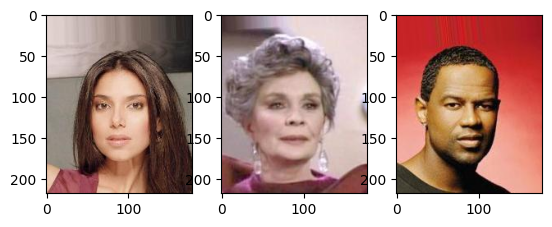

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/refs/heads/fall24/week09_generative/yfile.py -O yfile.py
from yfile import download_from_yadisk
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
  print("Downloading...") # this will download 1.4 gb file, downloading will take some time (8-10 minutes)
  download_from_yadisk(short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
                        filename=FILENAME, target_dir=TARGET_DIR)
  # alternative manual download:  https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW

  print("Extracting...")
  !unzip celeba.zip  # extract images; you don't need to run it every time
  print("Done!")
else:
  print("Found previously downloaded data!")

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
assert filesize > 2 ** 30, "{filesize} GiB is too small, something wrong with downloading - please clean up and re-download"

import matplotlib.pyplot as plt
plt.subplot(131); plt.imshow(plt.imread("celeba/celeba/img_align_celeba/100019.jpg"))
plt.subplot(132); plt.imshow(plt.imread("celeba/celeba/img_align_celeba/000084.jpg"))
plt.subplot(133); plt.imshow(plt.imread("celeba/celeba/img_align_celeba/148483.jpg"))

## Prepare the data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [3]:
# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment-out .Grayscale below :)


class CropCelebA64:  # custom preprocessing for CelebA
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic
    def __repr__(self):
        return self.__class__.__name__ + '()'


train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
    #download=True,   # in case of problems with downloading from gdrive above
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
)

In [4]:
# Hold out the first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [5]:
BATCH_SIZE = 64  # feel free to alter after initial tuning

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
print("Image batch shape:", next(iter(train_loader))[0].shape)

Image batch shape: torch.Size([64, 1, 64, 64])


# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [6]:
def init_xavier_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [59]:
class Autoencoder(nn.Module):
    def __init__(self, dimZ=256, inp_dim=4096, hidden_dim=2048):
        super().__init__()

        self.dimZ = dimZ
        self.inp_dim = inp_dim
        self.hidden_dim = hidden_dim
        self.encoder_h = nn.Linear(inp_dim, hidden_dim)
        self.encoder_z = nn.Linear(hidden_dim, dimZ)
        self.decoder_h = nn.Linear(dimZ, hidden_dim)
        self.decoder_out = nn.Linear(hidden_dim, inp_dim)

        self.apply(init_xavier_zero)

    def forward(self, x):
        B = x.size(0)
        x = x.view(B, -1)
        h = torch.relu(self.encoder_h(x))
        z = self.encoder_z(h)
        hd = torch.relu(self.decoder_h(z))
        out = torch.sigmoid(self.decoder_out(hd))
        out = out.view(B, 1, 64, 64)

        return out, z
    def decode(self, z):
        with torch.no_grad():
            hd = torch.relu(self.decoder_h(z))
            out = torch.sigmoid(self.decoder_out(hd))
            out = out.view(z.size(0), 1, 64, 64)
        return out

In [30]:
# Create MSE loss function
criterion = torch.nn.MSELoss()
autoencoder = Autoencoder().to(device)

In [31]:
from itertools import islice
# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [32]:
import os
import torch

def save_checkpoint(model, optimizer, epoch, path="ae_checkpoint.pth"):
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict()
    }, path)
    print(f"Saved checkpoint at epoch {epoch} → {path}")


def load_checkpoint(model, optimizer, path="ae_checkpoint.pth", device="cuda"):
    if os.path.exists(path):
        ckpt = torch.load(path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        print(f" Resuming from epoch {ckpt['epoch']+1}")
        return ckpt["epoch"] + 1  # next epoch
    else:
        print("No checkpoint found ")
        return 1


In [60]:
from torch.amp import autocast, GradScaler

def train_autoencoder(model, train_loader, val_loader, optimizer, criterion,
                      num_epochs, device, ckpt_path="ae_checkpoint.pth"):

    start_epoch = load_checkpoint(model, optimizer, ckpt_path, device)

    scaler = GradScaler("cuda")
    train_losses = []
    val_losses = []

    fixed_batch, _ = next(iter(val_loader))
    fixed_batch = fixed_batch.to(device)

    for epoch in range(start_epoch, num_epochs + 1):
        model.train()
        running_train_loss = 0.0
        n_train = 0

        for xb, _ in train_loader:
            xb = xb.to(device)

            optimizer.zero_grad(set_to_none=True)

            with autocast("cuda", dtype=torch.float16):
                recon, _ = model(xb)
                loss = criterion(recon, xb)

            if torch.isnan(loss):
                print(" NaN detected! Skipping batch.")
                continue

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item() * xb.size(0)
            n_train += xb.size(0)

        avg_train_loss = running_train_loss / n_train
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            xb, _ = next(iter(val_loader))
            xb = xb.to(device)
            recon, _ = model(xb)
            val_loss = criterion(recon, xb).item()

        val_losses.append(val_loss)

        print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f}")
        save_checkpoint(model, optimizer, epoch, ckpt_path)

        if epoch % 5 == 0 or epoch == num_epochs:
            with torch.no_grad():
                recon_fixed, _ = model(fixed_batch)

            plt.figure(figsize=(5,5))
            plt.imshow(make_grid(recon_fixed[:16].cpu().clamp(0,1), nrow=4).permute(1,2,0))
            plt.title(f"Reconstructions at Epoch {epoch}")
            plt.axis('off')
            plt.show()
            plt.close()

    return train_losses, val_losses

No checkpoint found 
[Epoch 1] Train Loss: 0.010325 | Val Loss: 0.005890
Saved checkpoint at epoch 1 → ae_checkpoint.pth
[Epoch 2] Train Loss: 0.005937 | Val Loss: 0.005200
Saved checkpoint at epoch 2 → ae_checkpoint.pth
[Epoch 3] Train Loss: 0.005452 | Val Loss: 0.004980
Saved checkpoint at epoch 3 → ae_checkpoint.pth


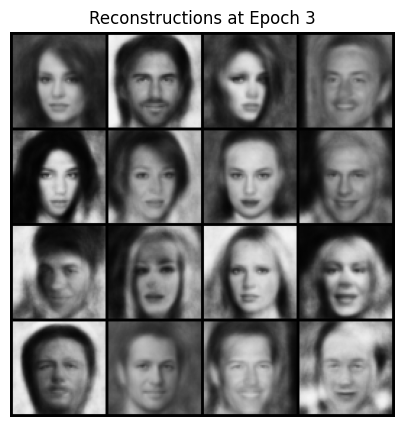

In [12]:
num_epochs = 3
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion_ae = nn.MSELoss()

train_losses, val_losses = train_autoencoder(
    autoencoder,
    train_loader,
    val_loader,
    optimizer_ae,
    criterion_ae,
    num_epochs,
    device
)

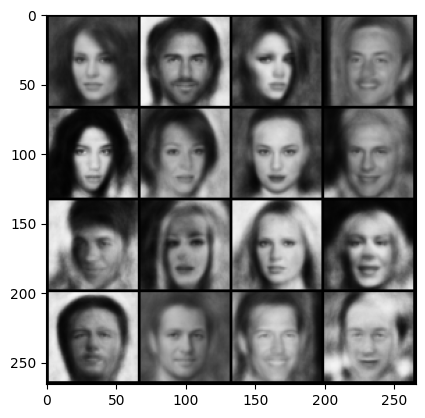

In [14]:
# Examine the reconstructions
from itertools import islice

images, _ = list(islice(val_loader, 1))[0]
reconstruction, latent_code = autoencoder(images.to(device))

reconstruction = reconstruction[:16].cpu()
plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

Reconstruction is not bad, right?  Okay, it very well might be bad, but it should at least be a blurry image.

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

(np.float64(-0.5), np.float64(331.5), np.float64(331.5), np.float64(-0.5))

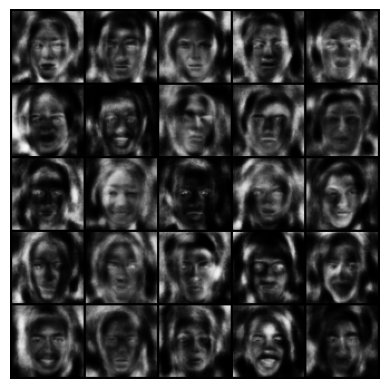

In [15]:
dimZ=256
z = torch.randn(25, dimZ) * 0.5
hd = torch.relu(autoencoder.decoder_h(z.to(device)))
reconstruction = torch.sigmoid(autoencoder.decoder_out(hd)).clamp(0, 1)

reconstruction = reconstruction.view(25, 1, 64, 64)

plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))
plt.axis("off")


So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self,
                 dimZ=100,
                 inp_dim=4096,
                 hidden_dim=512,
                 img_channels=1,
                 img_size=64):
        super().__init__()
        self.dimZ = dimZ
        self.inp_dim = inp_dim
        self.hidden_dim = hidden_dim
        self.img_channels = img_channels
        self.img_size = img_size

        # encoder
        self.encoder = nn.Linear(self.inp_dim, self.hidden_dim)
        self.enc_mu = nn.Linear(self.hidden_dim, self.dimZ)
        self.enc_logsigma = nn.Linear(self.hidden_dim, self.dimZ)

        # decoder
        self.decoder = nn.Linear(self.dimZ, self.hidden_dim)
        self.dec_mu = nn.Linear(self.hidden_dim, self.inp_dim)
        self.dec_logsigma = nn.Linear(self.hidden_dim, self.inp_dim)

        self.recon_act = nn.Sigmoid()
        self.apply(init_xavier_zero)
        with torch.no_grad():
            try:
                nn.init.constant_(self.dec_logsigma.bias, -3.0)
            except Exception:
                pass

    def gaussian_sampler(self, mu, logsigma):
        eps = torch.randn_like(mu)
        return mu + torch.exp(logsigma) * eps

    def encode(self, x):
        B = x.shape[0]
        x_flat = x.view(B, -1)
        h = F.relu(self.encoder(x_flat))
        latent_mu = self.enc_mu(h)
        latent_logsigma = self.enc_logsigma(h)
        return latent_mu, latent_logsigma

    def decode(self, z):
        B = z.shape[0]
        hd = F.relu(self.decoder(z))
        mu_flat = self.dec_mu(hd)
        out = self.recon_act(mu_flat)
        return out.view(B, self.img_channels, self.img_size, self.img_size)

    def forward(self, x):
        B = x.shape[0]
        latent_mu, latent_logsigma = self.encode(x)
        z = self.gaussian_sampler(latent_mu, latent_logsigma)

        hd = F.relu(self.decoder(z))
        recon_mu_flat = self.dec_mu(hd)
        recon_logsigma_flat = self.dec_logsigma(hd)

        recon_mu = self.recon_act(recon_mu_flat).view(
            B, self.img_channels, self.img_size, self.img_size
        )
        recon_logsigma = recon_logsigma_flat.view(
            B, self.img_channels, self.img_size, self.img_size
        )

        return recon_mu, recon_logsigma, latent_mu, latent_logsigma


And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [62]:
def KL_divergence(mu, logsigma):
    sigma2 = torch.exp(2.0 * logsigma)
    term = mu.pow(2) + sigma2 - 2.0 * logsigma - 1.0
    kl = 0.5 * torch.sum(term, dim=1)
    return kl


def log_likelihood(x, mu, logsigma):
    B = x.shape[0]
    device = x.device
    dtype = x.dtype

    var = torch.exp(2.0 * logsigma)

    const = -0.5 * torch.log(torch.tensor(2.0 * math.pi, device=device, dtype=dtype))

    ll_per_pixel = const - logsigma - 0.5 * ((x - mu).pow(2) / var)
    ll = torch.sum(ll_per_pixel.view(B, -1), dim=1)
    return ll


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    ll = log_likelihood(x, mu_gen, logsigma_gen)
    kl = KL_divergence(mu_z, logsigma_z)
    elbo = ll - kl
    loss = -torch.mean(elbo)
    return loss

And train the model:

[VAE] Epoch 01/3 | Train: -1894.972661 | Val: -2844.718491
[VAE] Epoch 02/3 | Train: -3834.073830 | Val: -4010.568840
[VAE] Epoch 03/3 | Train: -4250.900687 | Val: -4415.161700


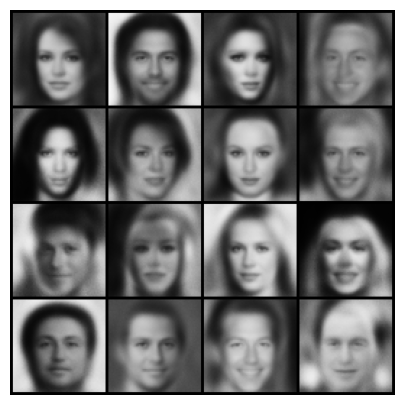

In [52]:
import math
import gc
torch.backends.cudnn.benchmark = True
vis_every = 3
use_visualization = True
vae = VAE(dimZ=dimZ).to(device)

optimizer = optim.AdamW(
    vae.parameters(),
    lr=2e-4,
    weight_decay=1e-4,
)

scaler = GradScaler("cuda")

use_ema = True
ema_decay = 0.999

# EMA copy
ema_vae = VAE(dimZ=dimZ).to(device)
ema_vae.load_state_dict(vae.state_dict())


@torch.no_grad()
def update_ema(model, ema_model, decay):
    for p, p_ema in zip(model.parameters(), ema_model.parameters()):
        if p.requires_grad:
            p_ema.data.mul_(decay).add_(p.data, alpha=1 - decay)

def train_vae_one_epoch(model, loader, optimizer, scaler, device):

    model.train()
    running_loss = 0.0
    total = 0
    gc.disable()

    for xb, _ in loader:
        xb = xb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", dtype=torch.float16):
            mu_gen, logsigma_gen, mu_z, logsigma_z = model(xb)
            loss = loss_vae(xb, mu_gen, logsigma_gen, mu_z, logsigma_z)

        if torch.isnan(loss):
            print("⚠ Skipping NaN batch")
            continue

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scaler.step(optimizer)
        scaler.update()

        bs = xb.size(0)
        running_loss += loss.item() * bs
        total += bs

        if use_ema:
            update_ema(model, ema_vae, ema_decay)

    gc.enable()  # restore

    return running_loss / total

def validate_vae(model, loader, device):

    model.eval()
    running_loss = 0.0
    total = 0

    with torch.no_grad(), autocast("cuda"):

        for xb, _ in loader:
            xb = xb.to(device, non_blocking=True)
            mu_gen, logsigma_gen, mu_z, logsigma_z = model(xb)
            loss = loss_vae(xb, mu_gen, logsigma_gen, mu_z, logsigma_z)

            bs = xb.size(0)
            running_loss += loss.item() * bs
            total += bs

    return running_loss / total

fixed_batch, _ = next(iter(val_loader))
fixed_batch = fixed_batch.to(device)

for epoch in range(1, num_epochs + 1):

    train_loss = train_vae_one_epoch(
        vae, train_loader, optimizer, scaler, device
    )

    model_eval = ema_vae if use_ema else vae
    val_loss = validate_vae(model_eval, val_loader, device)

    print(f"[VAE] Epoch {epoch:02d}/{num_epochs} | "
          f"Train: {train_loss:.6f} | Val: {val_loss:.6f}")
if use_visualization and (epoch % vis_every == 0):

    with torch.no_grad():
        mu_gen, _, _, _ = model_eval(fixed_batch.float())

    recon = (
        mu_gen[:16]
        .detach()
        .float()
        .cpu()
        .clamp(0, 1)
    )

    plt.figure(figsize=(5, 5))
    plt.imshow(make_grid(recon, nrow=4).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    plt.close("all")


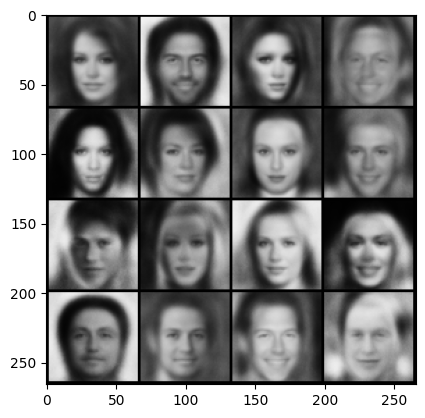

In [54]:
images, _ = list(islice(val_loader, 1))[0]
mu_gen, _, _, _ = vae(images.to(device))
reconstruction = mu_gen[:16].cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

And finally sample from VAE.

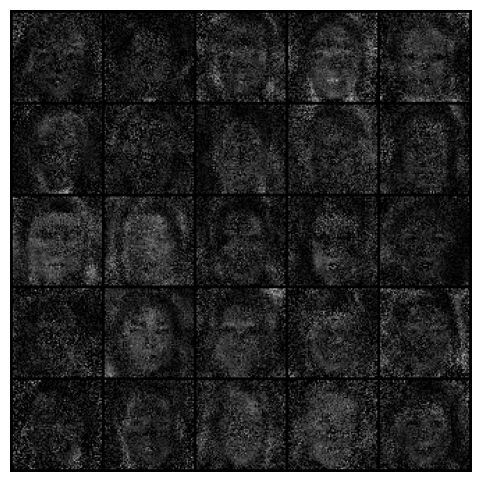

In [55]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
img_channels = 1
img_size = 64
with torch.no_grad():
    n_samples = 25
    z = torch.randn(n_samples, dimZ, device=device)  # sample z ~ N(0,1)
    hd = nn.functional.relu(vae.decoder(z))
    recon_mu_flat = vae.dec_mu(hd)
    recon_logsigma_flat = vae.dec_logsigma(hd)
    recon_mu = vae.recon_act(recon_mu_flat).view(n_samples, img_channels, img_size, img_size)
    recon_logsigma = recon_logsigma_flat.view(n_samples, img_channels, img_size, img_size)
    # sample pixels
    eps = torch.randn_like(recon_mu)
    sampled_vae = (recon_mu + torch.exp(recon_logsigma) * eps).clamp(0,1)
    plt.figure(figsize=(6,6))
    plt.imshow(make_grid(sampled_vae.cpu(), nrow=5).permute(1,2,0))
    plt.axis('off')
    plt.show()


Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now.

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

# If you made it here - Congrats! (and here's an optional bonus task)

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

Collected (cpu): torch.Size([10, 1, 64, 64]) torch.Size([10, 1, 64, 64])
AE diff shape: torch.Size([256]) VAE diff shape: torch.Size([256])


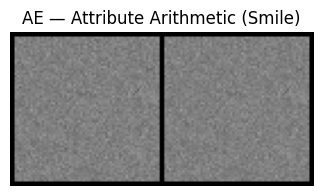

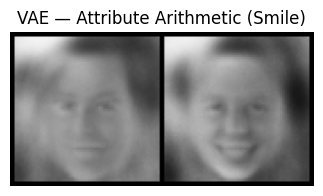

In [63]:

import numpy as np, gc
import matplotlib.pyplot as plt

SMILE_ATTR_INDEX = 31
attrs = train_dataset.attr
if isinstance(attrs, torch.Tensor):
    attrs_np = attrs.numpy()
else:
    attrs_np = np.array(attrs)
smile_indices = np.where(attrs_np[:, SMILE_ATTR_INDEX] == 1)[0]
nosmile_indices = np.where(attrs_np[:, SMILE_ATTR_INDEX] == 0)[0]

n_select = 10
smile_idx_sel = smile_indices[:n_select].tolist()
nosmile_idx_sel = nosmile_indices[:n_select].tolist()
if not smile_idx_sel or not nosmile_idx_sel:
    raise ValueError("No smiling or non-smiling images found! Check dataset or attribute indexing.")
def load_images_by_indices(dataset, idx_list, device, dtype=torch.float32):
    imgs = []
    for i in idx_list:
        img, _ = dataset[i]
        imgs.append(img.unsqueeze(0))
    imgs = torch.cat(imgs, dim=0).to(device=device, dtype=dtype)
    return imgs
smile_imgs_cpu = torch.cat([train_dataset[i][0].unsqueeze(0) for i in smile_idx_sel], dim=0)
nosmile_imgs_cpu = torch.cat([train_dataset[i][0].unsqueeze(0) for i in nosmile_idx_sel], dim=0)

print("Collected (cpu):", smile_imgs_cpu.shape, nosmile_imgs_cpu.shape)
autoencoder.eval(); vae.eval()
with torch.no_grad():
    z_smile_ae = autoencoder(smile_imgs_cpu.to(device))[1].detach().cpu()
    z_nosmile_ae = autoencoder(nosmile_imgs_cpu.to(device))[1].detach().cpu()
    _, _, mu_smile_vae, _ = vae(smile_imgs_cpu.to(device))
    _, _, mu_nosmile_vae, _ = vae(nosmile_imgs_cpu.to(device))
    z_smile_vae = mu_smile_vae.detach().cpu()
    z_nosmile_vae = mu_nosmile_vae.detach().cpu()
torch.cuda.empty_cache()
gc.collect()
smile_vec_ae = z_smile_ae.mean(dim=0)
nonsmile_vec_ae = z_nosmile_ae.mean(dim=0)
diff_ae = (smile_vec_ae - nonsmile_vec_ae).to(torch.float32)

smile_vec_vae = z_smile_vae.mean(dim=0)
nonsmile_vec_vae = z_nosmile_vae.mean(dim=0)
diff_vae = (smile_vec_vae - nonsmile_vec_vae).to(torch.float32)

print("AE diff shape:", diff_ae.shape, "VAE diff shape:", diff_vae.shape)
test_img_cpu = nosmile_imgs_cpu[0:1]

with torch.no_grad():
    # AE path
    z_orig_ae = autoencoder(test_img_cpu.to(device))[1].detach()
    z_smiled_ae = (z_orig_ae + diff_ae.to(device).unsqueeze(0)).to(device)
    hd = torch.relu(autoencoder.decoder_h(z_smiled_ae))
    out = autoencoder.decoder_out(hd)
    recon_smile_ae = torch.sigmoid(out).detach().cpu()
    z_orig_ae0 = autoencoder(test_img_cpu.to(device))[1].detach()
    hd0 = torch.relu(autoencoder.decoder_h(z_orig_ae0))
    recon_orig_ae = torch.sigmoid(autoencoder.decoder_out(hd0)).detach().cpu()
    mu_z = vae(test_img_cpu.to(device))[2].detach()
    z_smiled_vae = (mu_z + diff_vae.to(device).unsqueeze(0)).to(device)
    hd = torch.relu(vae.decoder(z_smiled_vae))
    mu_flat = vae.dec_mu(hd)
    recon_smile_vae = vae.recon_act(mu_flat).detach().cpu()
    mu_flat0 = vae.dec_mu(torch.relu(vae.decoder(mu_z)))
    recon_orig_vae = vae.recon_act(mu_flat0).detach().cpu()
recon_orig_ae = recon_orig_ae.view(1, img_channels, img_size, img_size).cpu().clamp(0,1)
recon_smile_ae = recon_smile_ae.view(1, img_channels, img_size, img_size).cpu().clamp(0,1)
recon_orig_vae = recon_orig_vae.view(1, img_channels, img_size, img_size).cpu().clamp(0,1)
recon_smile_vae = recon_smile_vae.view(1, img_channels, img_size, img_size).cpu().clamp(0,1)

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_pair(title, imgA, imgB):
    grid = make_grid(torch.cat([imgA, imgB], dim=0), nrow=2)  # (C, H, W)
    grid = grid.detach().cpu()
    if grid.shape[0] == 1:
        # grayscale
        arr = grid[0].numpy()           # (H, W)
        cmap = "gray"
    else:
        # RGB
        arr = grid.permute(1, 2, 0).numpy()  # (H, W, C)
        cmap = None

    plt.figure(figsize=(4, 2))
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()
show_pair("AE — Attribute Arithmetic (Smile)",
          recon_orig_ae.float(), recon_smile_ae.float())

show_pair("VAE — Attribute Arithmetic (Smile)",
          recon_orig_vae.float(), recon_smile_vae.float())
